This is our import section

In [1]:
import tensorflow as tf
import glob
import os
import cv2
import random
import math
import sys
import numpy as np
from matplotlib import pyplot as plt
from random import randint

# This is needed to display the images.
%matplotlib inline

Some basic configuration

In [2]:
# Configuration
image_types = ["red", "green", "yellow"]
input_img_x = 32
input_img_y = 32
train_test_split_ratio = 0.9
epochs = 50
batch_size = 32

# Input and output
x = tf.placeholder(tf.float32, shape=[None, input_img_x, input_img_y, 3])
y_ = tf.placeholder(tf.float32, shape=[None, len(image_types)])

Build our model here

In [3]:
# Helper layer functions
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# Our first convolutional layer of 16 3x3 filters
W_conv1 = weight_variable([3, 3, 3, 16])
b_conv1 = bias_variable([16])
h_conv1 = tf.nn.relu(conv2d(x, W_conv1, 1) + b_conv1)

# Our second convolutional layer of 16 3x3 filters
W_conv2 = weight_variable([3, 3, 16, 16])
b_conv2 = bias_variable([16])
h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 1) + b_conv2)

# Our third convolutional layer of 16 3x3 filters
W_conv3 = weight_variable([3, 3, 16, 16])
b_conv3 = bias_variable([16])
h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 1) + b_conv3)

# Do max-pooling
h_pool4 = max_pool_2x2(h_conv3)
n1, n2, n3, n4 = h_pool4.get_shape().as_list()
W_fc1 = weight_variable([n2*n3*n4, 3])
b_fc1 = bias_variable([3])

# We flatten our pool layer into a fully connected layer
h_pool4_flat = tf.reshape(h_pool4, [-1, n2*n3*n4])

# This is our output with the three classes
y = tf.matmul(h_pool4_flat, W_fc1) + b_fc1

Loss, optimizer and initialization

In [4]:
# Create a new session
sess = tf.InteractiveSession()

# Use softmax cross-entropy with logits as loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))

# Use adam with learning rate 0.0001 as optimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

# Initialize all variables
sess.run(tf.global_variables_initializer())

Load traffic light dataset from files and shuffle it

In [5]:
full_set = []
for im_type in image_types:
    for ex in glob.glob(os.path.join("dataset/", im_type, "*")):
        im = cv2.imread(ex)
        if not im is None:
            # Resize image
            im = cv2.resize(im, (input_img_x, input_img_y))

            # Convert to RGB
            im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR) 
            
            # Create an array representing our classes and set it
            one_hot_array = [0] * len(image_types)
            one_hot_array[image_types.index(im_type)] = 1
            assert(im.shape == (input_img_x, input_img_y, 3))

            # Add it to our set
            full_set.append((im, one_hot_array, ex))

# Shuffle the data
random.shuffle(full_set)

Create train / validation set with predefined split

In [6]:
# We split our data into a training and test set here
split_index = int(math.floor(len(full_set) * train_test_split_ratio))
train_set = full_set[:split_index]
test_set = full_set[split_index:]

# We ensure that our training and test sets are a multiple of batch size
train_set_offset = len(train_set) % batch_size
test_set_offset = len(test_set) % batch_size
train_set = train_set[: len(train_set) - train_set_offset]
test_set = test_set[: len(test_set) - test_set_offset]

train_x, train_y, train_z = zip(*train_set)
test_x, test_y, test_z = zip(*test_set)

Train our neural network

In [7]:
print("Starting training... [{} training examples]".format(len(train_x)))

v_loss = least_loss = 99999999
checkpoint_name = "./model/model_classification.ckpt"
train_loss = []
val_loss = []
saver = tf.train.Saver()

# Iterate over the epochs
for i in range(0, epochs):
    
    # Iterate over our training set
    for tt in range(0, int((len(train_x) / batch_size))):
        start_batch = batch_size * tt
        end_batch = batch_size * (tt + 1)
        train_step.run(feed_dict={x: train_x[start_batch:end_batch], y_: train_y[start_batch:end_batch]})
        ex_seen = "Current epoch, examples seen: {:20} / {} \r".format(tt * batch_size, len(train_x))
        sys.stdout.write(ex_seen.format(tt * batch_size))
        sys.stdout.flush()

    ex_seen = "Current epoch, examples seen: {:20} / {} \r".format((tt + 1) * batch_size, len(train_x))
    sys.stdout.write(ex_seen.format(tt * batch_size))
    sys.stdout.flush()

    t_loss = loss.eval(feed_dict={x: train_x, y_: train_y})
    v_loss = loss.eval(feed_dict={x: test_x, y_: test_y})
    
    train_loss.append(t_loss)
    val_loss.append(v_loss)

    sys.stdout.write("Epoch {:5}: loss: {:15.10f}, val. loss: {:15.10f}".format(i + 1, t_loss, v_loss))

    if v_loss < least_loss:
        sys.stdout.write(", saving new best model to {}".format(checkpoint_name))
        least_loss = v_loss
        filename = saver.save(sess, checkpoint_name)

    sys.stdout.write("\n")

Starting training... [1312 training examples]
Epoch     1: loss:    8.5917139053, val. loss:    9.8821258545, saving new best model to ./model/model_classification.ckpt
Epoch     2: loss:    4.4265995026, val. loss:    6.0461769104, saving new best model to ./model/model_classification.ckpt
Epoch     3: loss:    1.9310842752, val. loss:    3.8682405949, saving new best model to ./model/model_classification.ckpt
Epoch     4: loss:    0.9335998893, val. loss:    3.5054795742, saving new best model to ./model/model_classification.ckpt
Epoch     5: loss:    0.5498634577, val. loss:    2.6588649750, saving new best model to ./model/model_classification.ckpt
Epoch     6: loss:    0.3957276642, val. loss:    2.3907012939, saving new best model to ./model/model_classification.ckpt
Epoch     7: loss:    0.2824176550, val. loss:    2.0910637379, saving new best model to ./model/model_classification.ckpt
Epoch     8: loss:    0.2411591411, val. loss:    1.9644572735, saving new best model to ./mo

Show training and validation loss

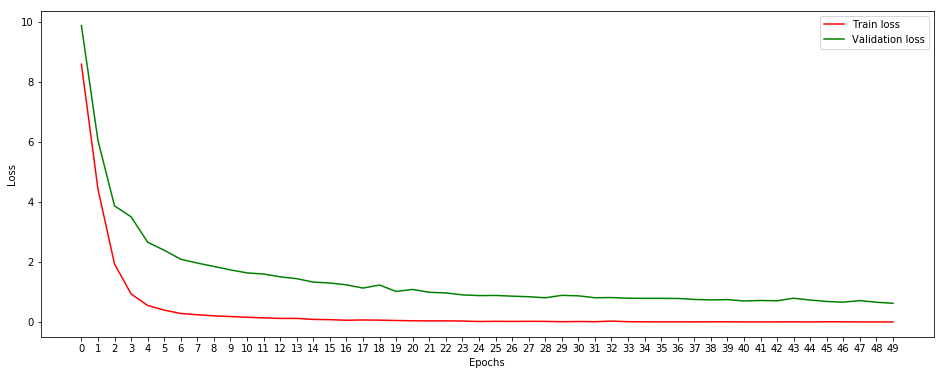

In [12]:
plt.figure(figsize=(16, 6))
plt.xticks(np.arange(0, len(train_loss), 1.0))
plt.ylabel("Loss")
plt.xlabel("Epochs")
train_line = plt.plot(range(0, len(train_loss)), train_loss, 'r', label="Train loss")
val_line = plt.plot(range(0, len(val_loss)), val_loss, 'g', label="Validation loss")
plt.legend()
plt.show()

Restore the model and weights from file

In [13]:
saver = tf.train.import_meta_graph('model/model_classification.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('model/'))
graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from model/model_classification.ckpt


Load a test image and do prediction

red


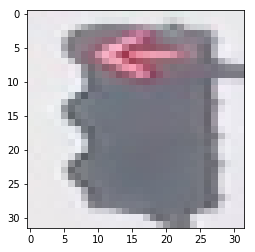

In [32]:
def predict(image):
    sfmax = list(sess.run(tf.nn.softmax(y.eval(feed_dict={x: [image]})))[0])
    sf_ind = sfmax.index(max(sfmax))
    predicted_label = image_types[sf_ind]
    return predicted_label

image = test_x[randint(0, len(test_x))]
plt.imshow(image)
print(predict(image))